In [2]:
# ===========================================#
#                                           #
#                                           #
# ----------CROSSWALK RECOGNITION------------#
# -----------WRITTEN BY N.DALAL--------------#
# -----------------2017 (c)------------------#
#                                           #
#                                           #
# ===========================================#

# Copyright by N. Dalal, 2017 (c)

# Licensed under the MIT License:

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import numpy as np
import cv2
import math
import scipy.misc
import PIL.Image
import statistics
import timeit
import glob
from sklearn import linear_model, datasets

import matplotlib.pyplot as plt


# ==========================#
# ---------functions--------#
# ==========================#

# get a line from a point and unit vectors
def lineCalc(vx, vy, x0, y0):
    scale = 10
    x1 = x0 + scale * vx
    y1 = y0 + scale * vy
    m = (y1 - y0) / (x1 - x0)
    b = y1 - m * x1
    return m, b


# the angle at the vanishing point
def angle(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    inner_product = x1 * x2 + y1 * y2
    len1 = math.hypot(x1, y1)
    len2 = math.hypot(x2, y2)
    print(len1)
    print(len2)
    a = math.acos(inner_product / (len1 * len2))
    return a * 180 / math.pi


# vanishing point - cramer's rule
def lineIntersect(m1, b1, m2, b2):
    # a1*x+b1*y=c1
    # a2*x+b2*y=c2
    # convert to cramer's system
    a_1 = -m1
    b_1 = 1
    c_1 = b1

    a_2 = -m2
    b_2 = 1
    c_2 = b2

    d = a_1 * b_2 - a_2 * b_1  # determinant
    dx = c_1 * b_2 - c_2 * b_1
    dy = a_1 * c_2 - a_2 * c_1

    intersectionX = dx / d
    intersectionY = dy / d
    return intersectionX, intersectionY


# process a frame
def process(im):
    start = timeit.timeit()  # start timer

    # initialize some variables
    x = W
    y = H

    radius = 250  # px
    thresh = 170
    bw_width = 170

    bxLeft = []
    byLeft = []
    bxbyLeftArray = []
    bxbyRightArray = []
    bxRight = []
    byRight = []
    boundedLeft = []
    boundedRight = []

    # 1. filter the white color
    lower = np.array([170, 170, 170])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(im, lower, upper)

    # 2. erode the frame
    erodeSize = int(y / 30)
    erodeStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (erodeSize, 1))
    erode = cv2.erode(mask, erodeStructure, (-1, -1))

    # 3. find contours and  draw the green lines on the white strips
    _, contours, hierarchy = cv2.findContours(erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    for i in contours:
        bx, by, bw, bh = cv2.boundingRect(i)

        if (bw > bw_width):
            cv2.line(im, (bx, by), (bx + bw, by), (0, 255, 0), 2)  # draw the a contour line
            bxRight.append(bx + bw)  # right line
            byRight.append(by)  # right line
            bxLeft.append(bx)  # left line
            byLeft.append(by)  # left line
            bxbyLeftArray.append([bx, by])  # x,y for the left line
            bxbyRightArray.append([bx + bw, by])  # x,y for the left line
            cv2.circle(im, (int(bx), int(by)), 5, (0, 250, 250), 2)  # circles -> left line
            cv2.circle(im, (int(bx + bw), int(by)), 5, (250, 250, 0), 2)  # circles -> right line

    # calculate median average for each line
    medianR = np.median(bxbyRightArray, axis=0)
    medianL = np.median(bxbyLeftArray, axis=0)

    bxbyLeftArray = np.asarray(bxbyLeftArray)
    bxbyRightArray = np.asarray(bxbyRightArray)

    # 4. are the points bounded within the median circle?
    for i in bxbyLeftArray:
        if (((medianL[0] - i[0]) ** 2 + (medianL[1] - i[1]) ** 2) < radius ** 2) == True:
            boundedLeft.append(i)

    boundedLeft = np.asarray(boundedLeft)

    for i in bxbyRightArray:
        if (((medianR[0] - i[0]) ** 2 + (medianR[1] - i[1]) ** 2) < radius ** 2) == True:
            boundedRight.append(i)

    boundedRight = np.asarray(boundedRight)

    # 5. RANSAC Algorithm

    # select the points enclosed within the circle (from the last part)
    bxLeft = np.asarray(boundedLeft[:, 0])
    byLeft = np.asarray(boundedLeft[:, 1])
    bxRight = np.asarray(boundedRight[:, 0])
    byRight = np.asarray(boundedRight[:, 1])

    # transpose x of the right and the left line
    bxLeftT = np.array([bxLeft]).transpose()
    bxRightT = np.array([bxRight]).transpose()

    # run ransac for LEFT
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    ransacX = model_ransac.fit(bxLeftT, byLeft)
    inlier_maskL = model_ransac.inlier_mask_  # right mask

    # run ransac for RIGHT
    ransacY = model_ransac.fit(bxRightT, byRight)
    inlier_maskR = model_ransac.inlier_mask_  # left mask

    # draw RANSAC selected circles
    for i, element in enumerate(boundedRight[inlier_maskR]):
        # print(i,element[0])
        cv2.circle(im, (element[0], element[1]), 10, (250, 250, 250), 2)  # circles -> right line

    for i, element in enumerate(boundedLeft[inlier_maskL]):
        # print(i,element[0])
        cv2.circle(im, (element[0], element[1]), 10, (100, 100, 250), 2)  # circles -> right line

    # 6. Calcuate the intersection point of the bounding lines
    # unit vector + a point on each line
    vx, vy, x0, y0 = cv2.fitLine(boundedLeft[inlier_maskL], cv2.DIST_L2, 0, 0.01, 0.01)
    vx_R, vy_R, x0_R, y0_R = cv2.fitLine(boundedRight[inlier_maskR], cv2.DIST_L2, 0, 0.01, 0.01)

    # get m*x+b
    m_L, b_L = lineCalc(vx, vy, x0, y0)
    m_R, b_R = lineCalc(vx_R, vy_R, x0_R, y0_R)

    # calculate intersention
    intersectionX, intersectionY = lineIntersect(m_R, b_R, m_L, b_L)

    # 7. draw the bounding lines and the intersection point
    m = radius * 10
    if (intersectionY < H / 2):
        cv2.circle(im, (int(intersectionX), int(intersectionY)), 10, (0, 0, 255), 15)
        cv2.line(im, (x0 - m * vx, y0 - m * vy), (x0 + m * vx, y0 + m * vy), (255, 0, 0), 3)
        cv2.line(im, (x0_R - m * vx_R, y0_R - m * vy_R), (x0_R + m * vx_R, y0_R + m * vy_R), (255, 0, 0), 3)

    # 8. calculating the direction vector
    POVx = W / 2  # camera POV - center of the screen
    POVy = H / 2  # camera POV - center of the screen

    Dx = -int(intersectionX - POVx)  # regular x,y axis coordinates
    Dy = -int(intersectionY - POVy)  # regular x,y axis coordinates

    # focal length in pixels = (image width in pixels) * (focal length in mm) / (CCD width in mm)
    focalpx = int(W * 4.26 / 6.604)  # all in mm

    end = timeit.timeit()  # STOP TIMER
    time_ = end - start

    print('DELTA (x,y from POV):' + str(Dx) + ',' + str(Dy))
    return im, Dx, Dy

In [3]:
def imshow(img):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    return plt.show()

C:\Users\Hakjong\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Hakjong\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Failed to process frame


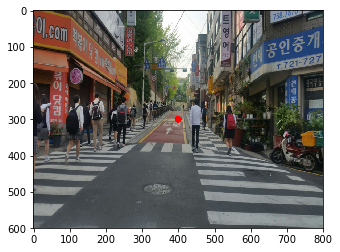

In [12]:
# =============================#
# ---------MAIN PROGRAM--------#
# =============================#
# initialization


# Define a new resolution
W = 800
H = 600

# setup the parameters for saving the processed file
Dx = []
Dy = []
after = 0
DxAve = 0
Dxold = 0
DyAve = 0
Dyold = 0
i = 0
state = ""
img = cv2.imread('img6.jpg')
img = scipy.misc.imresize(img, (H, W))

# draw camera's POV
cv2.circle(img, (int(W / 2), int(H / 2)), 5, (0, 0, 255), 8)

try:
    processedFrame, dx, dy = process(img)

    if (i < 6):
        Dx.append(dx)
        Dy.append(dy)
        i = i + 1

    else:
        DxAve = sum(Dx) / len(Dx)
        DyAve = sum(Dy) / len(Dy)
        del Dx[:]
        del Dy[:]
        i = 0

    if (DyAve > 30) and (abs(DxAve) < 300):
        # check if the vanishing point and the next vanishing point aren't too far from each other
        if (((DxAve - Dxold) ** 2 + (DyAve - Dyold) ** 2) < 150 ** 2) == True:  ##distance 150 px max
            cv2.line(img, (int(W / 2), int(H / 2)), (int(W / 2) + int(DxAve), int(H / 2) + int(DyAve)), (0, 0, 255),
                     7)

            # walking directions
            if abs(DxAve) < 80 and DyAve > 100 and abs(Dxold - DxAve) < 20:
                state = 'Straight'
                cv2.putText(img, state, (50, 50), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 0), 2, cv2.LINE_AA)

            elif DxAve > 80 and DyAve > 100 and abs(Dxold - DxAve) < 20:
                state = 'Right'
                cv2.putText(img, state, (50, 50), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 2, cv2.LINE_AA)

            elif DxAve < 80 and DyAve > 100 and abs(Dxold - DxAve) < 20:
                state = 'Left'
                cv2.putText(img, state, (50, 50), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 2, cv2.LINE_AA)
        else:
            cv2.line(img, (int(W / 2), int(H / 2)), (int(W / 2) + int(Dxold), int(H / 2) + int(Dyold)),
                     (0, 0, 255), )

        # walking directions
        if state == 'Straight':
            cv2.putText(img, state, (50, 50), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 0), 2, cv2.LINE_AA)
        else:
            cv2.putText(img, state, (50, 50), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 2, cv2.LINE_AA)

        Dxold = DxAve
        Dyold = DyAve

except:
    print('Failed to process frame')

# show & save
imshow(img)